# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. 
> Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. 

In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.

<img src="notebook_ims/vgg_16_architecture.png" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but **replace the final fully-connected layer** with our own classifier. This way we can use VGGNet as a _fixed feature extractor_ for our images then easily train a simple classifier on top of that. 
* Use all but the last fully-connected layer as a fixed feature extractor.
* Define a new, final classification layer and apply it to a task of our choice!

You can read more about transfer learning from [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).

---

## Flower power

Here we'll be using VGGNet to classify images of flowers. We'll start, as usual, by importing our usual resources. And checking if we can train our model on GPU.

### Download Data

The flower data is available in a zip file in this lesson's resources, for download to your local environment. In the case of this notebook, the data is already downloaded and in the directory `flower_photos/`.

In [56]:
import os
import numpy as np
import copy
import time
import random
import torch
import torch.nn as nn
import PIL.Image

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# see https://github.com/pytorch/pytorch/issues/7068
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic=True

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "cpu")    

CUDA is available!  Training on GPU ...


## Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class which makes is very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [4]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [57]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
image_size = 224  # 256

# Can supply different image normalisation here...
img_means = None
img_std = None

# Added the expected normalisation 
if img_means is not None:
    imgmeans = img_means
else: 
    imgmeans = [0.485, 0.456, 0.406]

if img_std is not None:
    imgstd = img_std
else: 
    imgstd = [0.229, 0.224, 0.225]

# data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
#                                       transforms.ToTensor()])

# Replaced with optimal image augmentation 
train_transform = transforms.Compose([transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(1.0, 1.5), 
                                                         shear=None, resample=PIL.Image.BILINEAR, fillcolor=0),
                                       transforms.Resize(image_size + (image_size//7), interpolation=PIL.Image.BILINEAR),
                                       transforms.CenterCrop(image_size),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05), 
                                       transforms.ToTensor(),
                                       transforms.Normalize(imgmeans, imgstd)])

test_transform  = transforms.Compose([transforms.Resize(image_size + (image_size//7)),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(imgmeans, imgstd)])
                                 
train_data = datasets.ImageFolder(train_dir, transform=train_transform) # was just data_transform 
test_data = datasets.ImageFolder(test_dir, transform=test_transform)    # was just data_transform

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [58]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [59]:
# For use in training loop
image_datasets = {'train': train_data, 'valid': None, 'test': test_data}

#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
dataset_sizes = {'train': len(train_data), 'valid': 0, 'test': len(test_data)}

dataloaders = {'train': train_loader, 'valid': None, 'test': test_loader}

In [98]:
def imshow(image, ax=None, title=None, color="black", filename=None, normalize=True):
    """Imshow for Tensor."""
    
    global img_means, img_std
    
    if img_means is not None:
        imgmeans = img_means
    else: 
        imgmeans = [0.485, 0.456, 0.406]

    if img_std is not None:
        imgstd = img_std
    else: 
        imgstd = [0.229, 0.224, 0.225]
        
    if isinstance(image, torch.Tensor): 
        image = image.cpu()
        image = copy.deepcopy(image.numpy())
        
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    if isinstance(image, np.ndarray):     # type(image).__module__ == "numpy":    #
        image = image.transpose((1, 2, 0))
    else:
        image = image.numpy.transpose((1, 2, 0))
    
    
    if normalize:
        # Undo preprocessing
        mean = np.array(imgmeans)
        std = np.array(imgstd)
        image = std * image + mean
        # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
        image = np.clip(image, 0, 1)

    if title is not None:
        ax.set_title(title, color=color)
    if filename is not None: 
        ax.set_xlabel(filename)
        
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

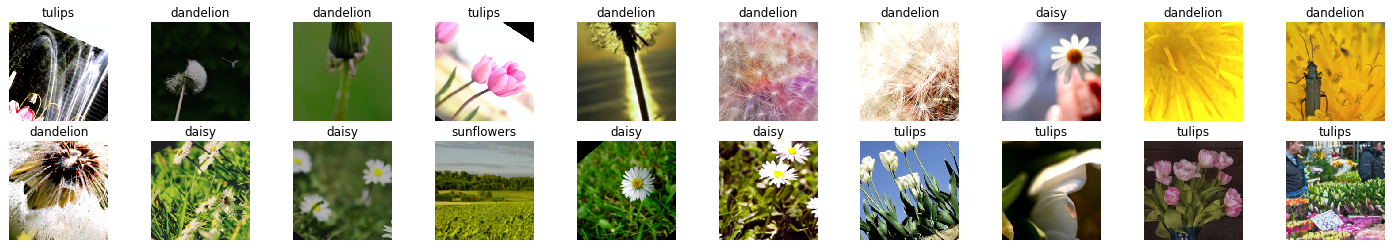

In [99]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    #ax.set_title(classes[labels[idx]])
    
    # Since using transforms that include image normalisation we need to use imshow function...
    imshow(images[idx], ax=ax, title=classes[labels[idx]], color="black", filename=None, normalize=True)


---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [63]:
model_name = "vgg16"

In [64]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [65]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 


4096
1000


In [66]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    

---
### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers. 
> This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

You can access any layer in a pretrained network by name and (sometimes) number, i.e. `vgg16.classifier[6]` is the sixth layer in a group of layers named "classifier".

#### TODO: Replace the last fully-connected layer with one that produces the appropriate number of class scores.

In [67]:
## TODO: add a last linear layer  that maps n_inputs -> 5 flower classes
## new layers automatically have requires_grad = True
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(in_features=in_features, out_features=5, bias=True)

In [68]:
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=5, bias=True)


In [69]:
vgg16 = vgg16.to(device);

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent with a small learning rate. Note that the optimizer accepts as input _only_ the trainable parameters `vgg.classifier.parameters()`.

In [70]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
use_weights = False
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
# optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

learning_rate = 0.001
parameters = filter(lambda p: p.requires_grad, vgg16.parameters())
optimizer = optim.SGD(parameters, lr=learning_rate)

In [71]:
def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
       lr +=[ param_group['lr'] ]
    return lr

In [72]:
get_learning_rate(optimizer)

[0.001]

In [73]:
# These are referred to in many places so set now 
checkpt = ""
state_dicts_name = ""

In [74]:
from torch.optim import lr_scheduler

multistep = False
OnPlateau = False

# Decay LR by a factor of 0.1 every 14 epochs (9 for inception)
if OnPlateau == True:
    #exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=0.000001)
    exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
elif multistep==True:
    exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, [7, 13, 23], gamma=0.05) # gamma=0.1
else:
    # exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.1)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 7, gamma=0.05)
    # exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1)

---
## Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [75]:
## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time

### Training loop copied from my Pytorch challenge...

In [76]:
# Define these outside the program oncemso that training can continue from the previous point

In [77]:
train_losses, valid_losses, train_acc_history, val_acc_history, lr_hist = [], [], [], [], []
best_acc, best_epoch, epoch_loss_min = 0.0, 0, np.Inf

In [78]:
def train_model(model, criterion, optimizer, scheduler, use_scheduler=False, use_weights=False, 
                num_epochs=10, first_epoch=0, ufilename=None, is_inception=False):
    
# Define these outside the program so that training can continue from the previous point
#     train_losses, valid_losses = [], []
#     train_acc_history, val_acc_history = [], []
#     best_acc = 0.0
#     best_epoch = 0
#     epoch_loss_min = np.Inf   # track change in validation loss

    global train_losses, valid_losses, train_acc_history, val_acc_history, lr_hist
    global best_acc, best_epoch, epoch_loss_min
    global model_name
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_optim_wts = copy.deepcopy(optimizer.state_dict())

    curr_lr = get_learning_rate(optimizer)
   
    # Phases for training are ideally train and valid, allow for missing valid data
    if dataloaders['valid'] is not None:
        phases = ['train', 'valid']
    else:
        phases = ['train']

    # if first_epoch is used assume its to restart training at that point using 1-based indexing
    # so decrement by 1 then add the value to num_epochs
    if first_epoch > 0:
        first_epoch -= 1
        num_epochs = first_epoch + num_epochs
    
    for epoch in range(first_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 11)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                if use_scheduler==True: 
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        # using best accuracy - the max setting
                        scheduler.step(best_acc)
                    else:    
                        scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                    
                    outputs = model(inputs)
                    
                    if isinstance(outputs, tuple):
                        if epoch == first_epoch:
                            print("Outputs:", outputs)
                        
                        if is_inception and phase == 'train':
                            loss1 = criterion(outputs[0], labels)
                            loss2 = criterion(outputs[1], labels)
                            loss = loss1 + 0.4*loss2
                        else:    
                            loss = sum((criterion(o,labels) for o in outputs))
                    else:
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * (1 if use_weights==True else inputs.size(0))
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                curr_lr = get_learning_rate(optimizer)
                lr_hist.append(curr_lr)
                
                print("Learning rate: {}".format(curr_lr))
                
            if phase == 'valid':
                valid_losses.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                filename = model_name + '_acc_'
                if ufilename is not None:
                    filename = filename + ufilename + '_'
                else:    
                    if use_scheduler==True:
                        filename = filename + 'schd_'
                    if use_weights==True:
                        filename = filename + 'wgts_'
                filename = filename + str(epoch+1) 
                
                print('Accuracy has increased ({:.6f} --> {:.6f}).  Saving model as {}...'.format(
                    best_acc, epoch_acc,
                    filename))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_optim_wts = copy.deepcopy(optimizer.state_dict())
                torch.save(best_model_wts, filename + '.pt')
                torch.save(best_optim_wts, filename + '_optimizer.pt')               
                
            if phase == 'valid' and epoch_loss <= epoch_loss_min:
                filename = model_name + '_'
                if ufilename is not None:
                    filename = filename + ufilename + '_'
                else:    
                    if use_scheduler==True:
                        filename = filename + 'schd_'
                    if use_weights==True:
                        filename = filename + 'wgts_'
                filename = filename + str(epoch+1) 
                
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model as {}...'.format(
                epoch_loss_min,
                epoch_loss,
                filename))
                
                best_epoch = epoch+1
                
                torch.save(model.state_dict(), filename + '.pt')
                torch.save(optimizer.state_dict(), filename + '_optimizer.pt')
                epoch_loss_min = epoch_loss

        print()

    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    if dataloaders['valid'] is not None:
        print('Best validation Accuracy: {:4f}'.format(best_acc))
        print('Best validation Loss    : {:4f}'.format(epoch_loss_min))
        print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    if dataloaders['valid'] is not None:
        model.load_state_dict(best_model_wts)
        optimizer.load_state_dict(best_optim_wts)
    
    return model

In [79]:
# number of epochs to train the model
n_epochs = 4

In [80]:
vgg16 = train_model(vgg16, 
                    criterion, 
                    optimizer,
                    exp_lr_scheduler, 
                    use_scheduler=False, 
                    use_weights=use_weights, 
                    num_epochs=n_epochs,
                    first_epoch=0,
                    ufilename=None,
                    is_inception=(model_name=="inception"))

Epoch 1/4
-----------
Learning rate: [0.001]
train Loss: 1.0817 Acc: 0.6134

Epoch 2/4
-----------
Learning rate: [0.001]
train Loss: 0.6852 Acc: 0.7687

Epoch 3/4
-----------
Learning rate: [0.001]
train Loss: 0.5781 Acc: 0.8016

Epoch 4/4
-----------
Learning rate: [0.001]
train Loss: 0.5289 Acc: 0.8121

Training complete in 9m 29s


In [81]:
train_losses

[1.0816675521695196,
 0.6851687435144053,
 0.5780988720278389,
 0.5289231248366566]

**Losses before using normalisation and image augmentation:**
```
[0.8050251267969418, 0.6879055903742488, 0.6402999801567187, 0.594519958138085]
```

In [90]:
train_acc_history

[0.6134185303514377,
 0.7686900958466454,
 0.8015974440894569,
 0.8121405750798723]

---
## Testing

Below you see the test accuracy for each flower class.

In [91]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.427245

Test Accuracy of daisy: 91% (84/92)
Test Accuracy of dandelion: 91% (121/132)
Test Accuracy of roses: 73% (67/91)
Test Accuracy of sunflowers: 84% (85/101)
Test Accuracy of tulips: 79% (98/124)

Test Accuracy (Overall): 84% (455/540)


**Losses before using normalisation and image augmentation:**
```
Test Loss: 0.591927

Test Accuracy of daisy: 80% (74/92)
Test Accuracy of dandelion: 90% (119/132)
Test Accuracy of roses: 63% (58/91)
Test Accuracy of sunflowers: 80% (81/101)
Test Accuracy of tulips: 70% (88/124)

Test Accuracy (Overall): 77% (420/540)
```

### Visualize Sample Test Results

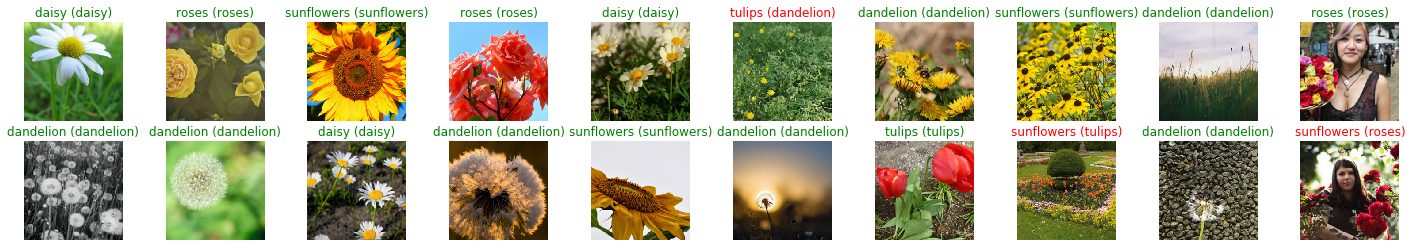

In [100]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
#     plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#     ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
#                  color=("green" if preds[idx]==labels[idx].item() else "red"))
    
    imshow(images[idx], ax=ax, title="{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"), filename=None, normalize=True)

# Appendix

In [31]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>